In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kushagratandon12/diabetic-retinopathy-balanced")

print("Path to dataset files:", path)

100%|██████████| 1.90G/1.90G [00:24<00:00, 84.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/kushagratandon12/diabetic-retinopathy-balanced/versions/1


In [2]:
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"maqsoodahmed110","key":"e719d1c587d31152872c5168d390c190"}'}

In [3]:
!pip install kaggle  # Install Kaggle CLI
!mkdir -p ~/.kaggle  # Create a directory for Kaggle API
!mv kaggle.json ~/.kaggle/  # Move kaggle.json to the correct folder
!chmod 600 ~/.kaggle/kaggle.json  # Secure permissions


In [4]:
#!/bin/bash
!kaggle datasets download -d kushagratandon12/diabetic-retinopathy-balanced

Dataset URL: https://www.kaggle.com/datasets/kushagratandon12/diabetic-retinopathy-balanced
License(s): CC0-1.0
 99% 1.87G/1.90G [00:11<00:00, 116MB/s]
100% 1.90G/1.90G [00:11<00:00, 177MB/s]


In [5]:
!unzip /content/diabetic-retinopathy-balanced.zip


Streaming output truncated to the last 5000 lines.
  inflating: content/Diabetic_Balanced_Data/val/2/30457_left.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30474_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30496_left._aug_21.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30496_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30509_right._aug_24.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30509_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30567_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30597_left._aug_28.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30597_left.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/3059_left.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/3070_right._aug_3.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/30717_right.jpeg  
  inflating: content/Diabetic_Balanced_Data/val/2/3074_left.jpeg  
  inflating: content/Diabetic_

In [6]:
!pip install torch torchvision matplotlib shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
import shap
import os
import random

# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


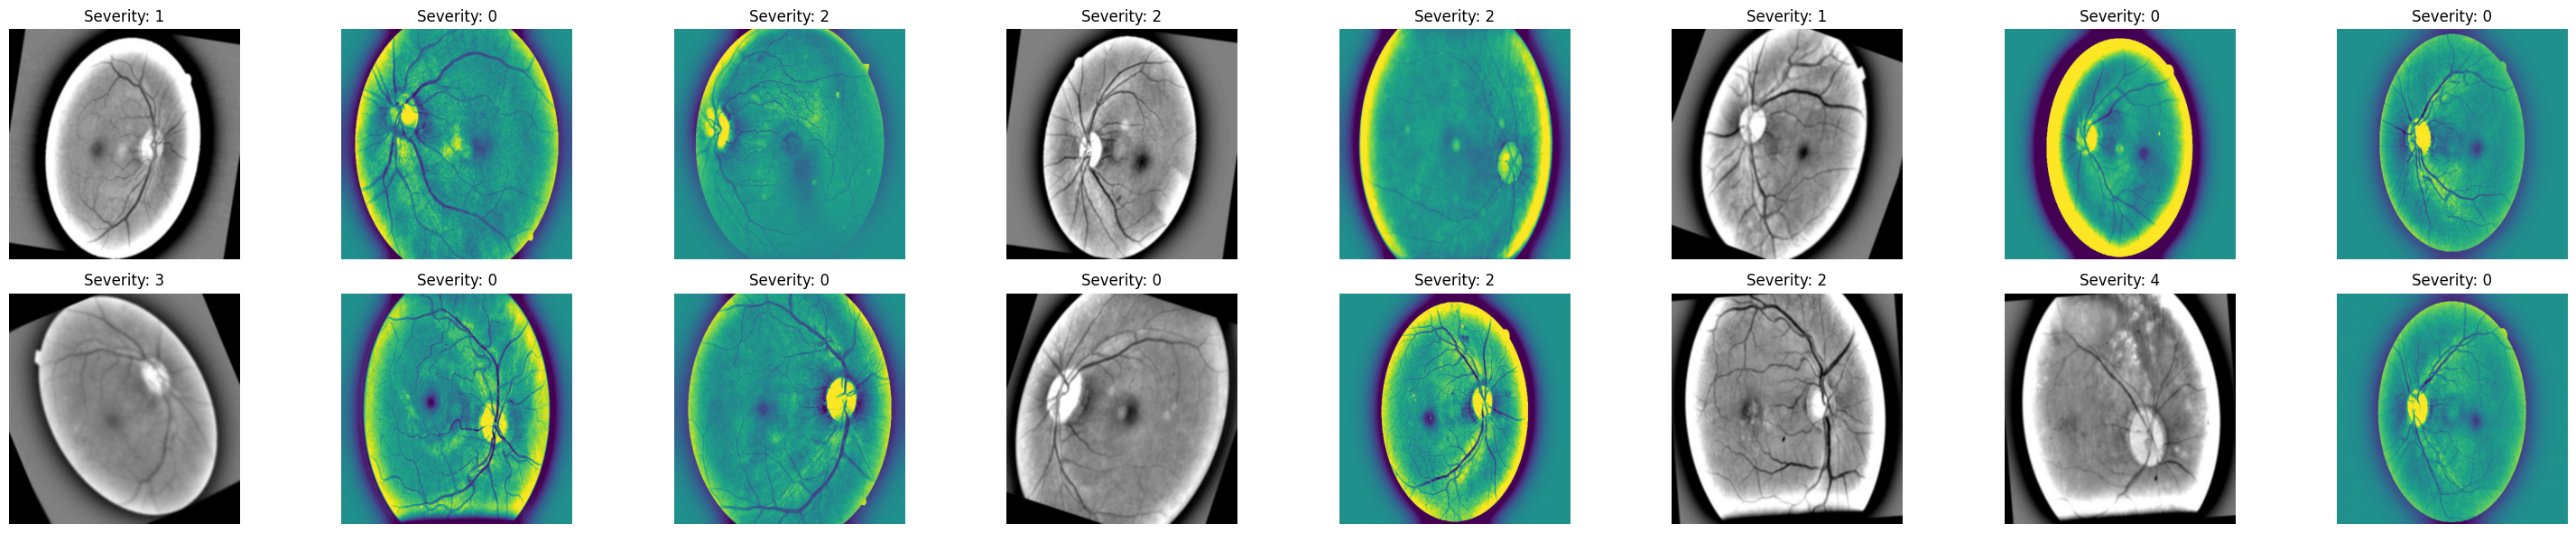

In [8]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset path
train_dir = "/content/data/Diabetic_Balanced_Data/train"

# Collect all image paths and their labels
image_paths = []
labels = []

for class_label in sorted(os.listdir(train_dir)):  # Iterate through class folders (0,1,2,3,4)
    class_dir = os.path.join(train_dir, class_label)

    if os.path.isdir(class_dir):  # Ensure it's a directory
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_label)  # Store label as string

# Handle small datasets
num_samples = min(16, len(image_paths))
selected_indices = random.sample(range(len(image_paths)), num_samples)

# Set up figure
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(30, 6))
axes = axes.flatten()

# Display images
for idx, img_idx in enumerate(selected_indices):
    img_path = image_paths[img_idx]
    image = Image.open(img_path)

    severity = labels[img_idx]  # Get severity from folder name

    axes[idx].imshow(image)
    axes[idx].set_title(f"Severity: {severity}")
    axes[idx].axis("off")

# Hide unused subplots if fewer images
for idx in range(num_samples, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


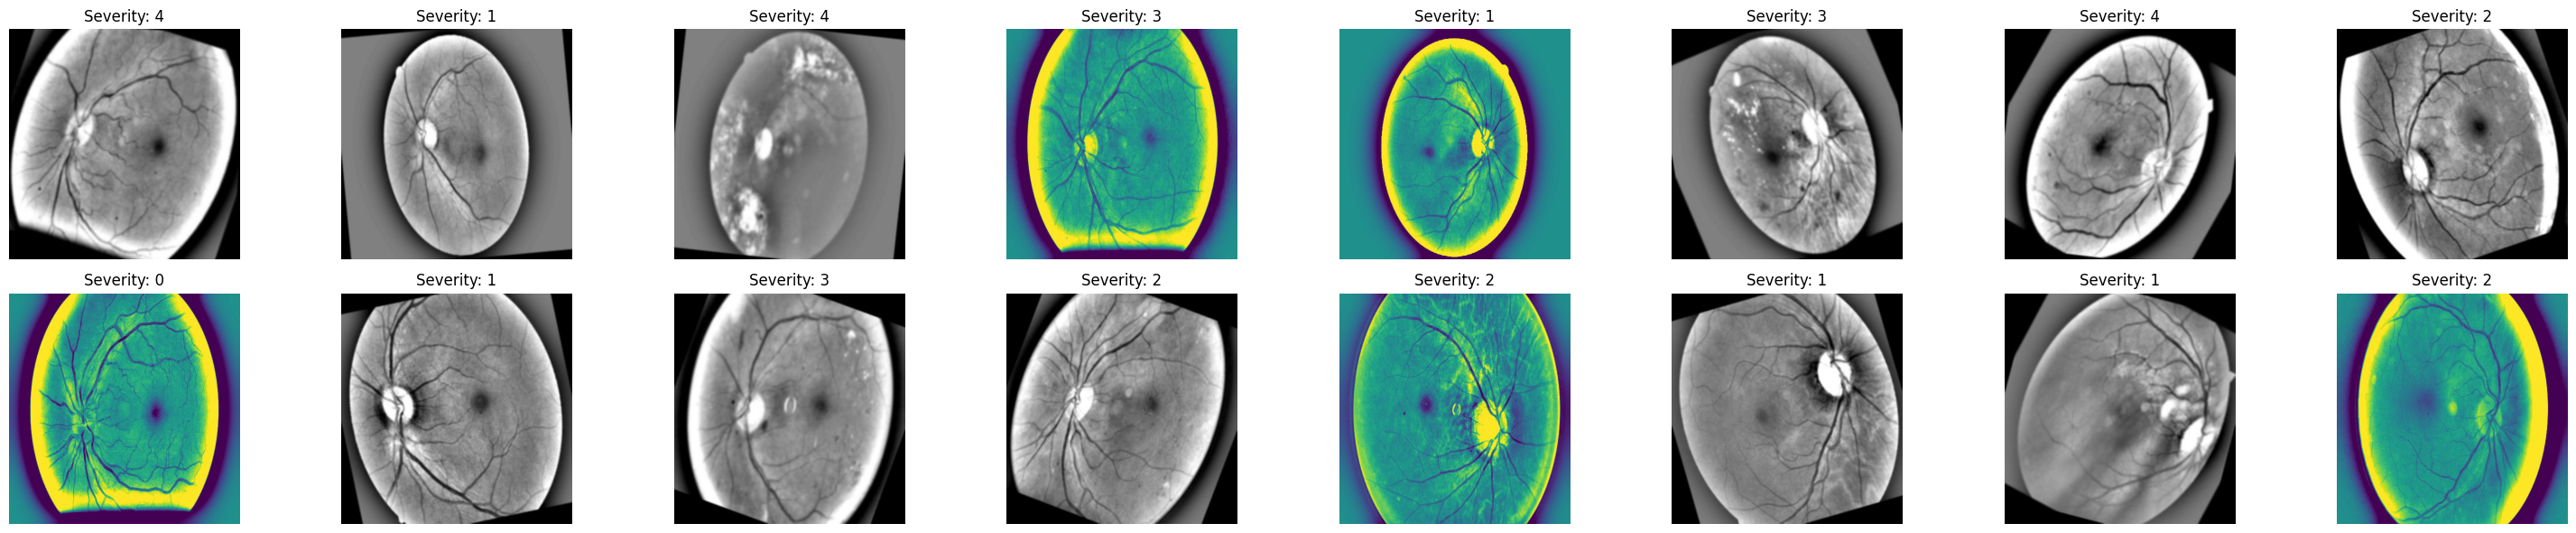

In [9]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Define dataset path
train_dir = "/content/data/Diabetic_Balanced_Data/test"

# Collect all image paths and their labels
image_paths = []
labels = []

for class_label in sorted(os.listdir(train_dir)):  # Iterate through class folders (0,1,2,3,4)
    class_dir = os.path.join(train_dir, class_label)

    if os.path.isdir(class_dir):  # Ensure it's a directory
        for img_name in os.listdir(class_dir):
            image_paths.append(os.path.join(class_dir, img_name))
            labels.append(class_label)  # Store label as string

# Handle small datasets
num_samples = min(16, len(image_paths))
selected_indices = random.sample(range(len(image_paths)), num_samples)

# Set up figure
fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(30, 6))
axes = axes.flatten()

# Display images
for idx, img_idx in enumerate(selected_indices):
    img_path = image_paths[img_idx]
    image = Image.open(img_path)

    severity = labels[img_idx]  # Get severity from folder name

    axes[idx].imshow(image)
    axes[idx].set_title(f"Severity: {severity}")
    axes[idx].axis("off")

# Hide unused subplots if fewer images
for idx in range(num_samples, len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()


In [10]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define dataset paths
data_dir = "/content/data/Diabetic_Balanced_Data"  # Change if needed
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")
test_dir = os.path.join(data_dir, "test")

# Load datasets (Automatically assigns labels from folder names)
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")


Classes: ['0', '1', '2', '3', '4']


In [11]:
# Load ResNet-50 with modified final layer
model = models.resnet50(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Output classes

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 148MB/s]


In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import f1_score
import numpy as np

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, epochs=10, patience=3):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float("inf")
    patience_counter = 0
    scaler = torch.cuda.amp.GradScaler()  # Mixed Precision Training

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        all_preds, all_labels = [], []

        # Training Loop
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            # Mixed Precision Forward Pass
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)

            # Backpropagation with GradScaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

        # Compute Training F1-score
        train_f1 = f1_score(all_labels, all_preds, average='weighted')
        avg_train_loss = running_loss / len(train_loader)

        # Validation Loop
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        # Learning Rate Scheduling
        if scheduler:
            scheduler.step(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Train F1: {train_f1:.4f} | Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}")

        # Early Stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save best model
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered. Training stopped.")
                break


In [15]:
train_model(model, train_loader, val_loader, criterion, optimizer,epochs=10, patience=3)


<ipython-input-12-bff87ce7c8b0>:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # Mixed Precision Training
Epoch 1/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 1/10 [Validation]: 100%|██████████| 311/311 [01:19<00:00,  3.94it/s]


Epoch 1/10: Train Loss: 0.9816, Train F1: 0.5735 | Val Loss: 0.8805, Val F1: 0.6164


Epoch 2/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 2/10 [Validation]: 100%|██████████| 311/311 [01:16<00:00,  4.04it/s]


Epoch 2/10: Train Loss: 0.8113, Train F1: 0.6548 | Val Loss: 0.7342, Val F1: 0.6798


Epoch 3/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 3/10 [Validation]: 100%|██████████| 311/311 [01:17<00:00,  3.99it/s]


Epoch 3/10: Train Loss: 0.6932, Train F1: 0.7021 | Val Loss: 0.7022, Val F1: 0.6976


Epoch 4/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 4/10 [Validation]: 100%|██████████| 311/311 [01:16<00:00,  4.06it/s]


Epoch 4/10: Train Loss: 0.6026, Train F1: 0.7430 | Val Loss: 0.6396, Val F1: 0.7225


Epoch 5/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 5/10 [Validation]: 100%|██████████| 311/311 [01:16<00:00,  4.06it/s]


Epoch 5/10: Train Loss: 0.5384, Train F1: 0.7692 | Val Loss: 0.6419, Val F1: 0.7336


Epoch 6/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/10 [Validation]: 100%|██████████| 311/311 [01:16<00:00,  4.07it/s]


Epoch 6/10: Train Loss: 0.4831, Train F1: 0.8021 | Val Loss: 0.6387, Val F1: 0.7325


Epoch 7/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 7/10 [Validation]: 100%|██████████| 311/311 [01:16<00:00,  4.08it/s]


Epoch 7/10: Train Loss: 0.4317, Train F1: 0.8228 | Val Loss: 0.5655, Val F1: 0.7638


Epoch 8/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 8/10 [Validation]: 100%|██████████| 311/311 [01:16<00:00,  4.08it/s]


Epoch 8/10: Train Loss: 0.3731, Train F1: 0.8513 | Val Loss: 0.5331, Val F1: 0.7863


Epoch 9/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 9/10 [Validation]: 100%|██████████| 311/311 [01:16<00:00,  4.09it/s]


Epoch 9/10: Train Loss: 0.3332, Train F1: 0.8680 | Val Loss: 0.5644, Val F1: 0.7797


Epoch 10/10 [Training]:   0%|          | 0/1088 [00:00<?, ?it/s]<ipython-input-12-bff87ce7c8b0>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 10/10 [Validation]: 100%|██████████| 311/311 [01:15<00:00,  4.12it/s]


Epoch 10/10: Train Loss: 0.2922, Train F1: 0.8865 | Val Loss: 0.5203, Val F1: 0.7985


Evaluating Model: 100%|██████████| 156/156 [00:41<00:00,  3.80it/s]


Test Loss: 0.5117

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.65      0.66      1000
           1       0.73      0.72      0.72       971
           2       0.67      0.72      0.69      1000
           3       0.97      0.91      0.94      1000
           4       0.96      0.98      0.97      1000

    accuracy                           0.80      4971
   macro avg       0.80      0.80      0.80      4971
weighted avg       0.80      0.80      0.80      4971



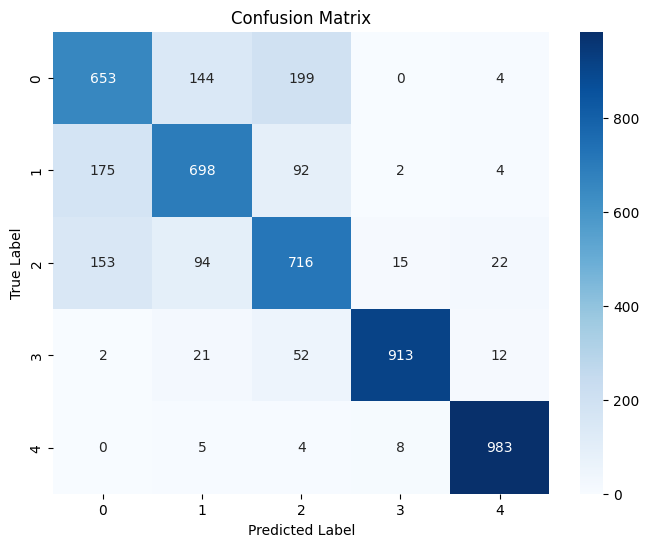

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating Model"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            all_preds.extend(torch.argmax(outputs, dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_test_loss = test_loss / len(test_loader)
    print(f"Test Loss: {avg_test_loss:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2,3,4], yticklabels=[0,1,2,3,4])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Run evaluation
evaluate_model(model, test_loader, criterion)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


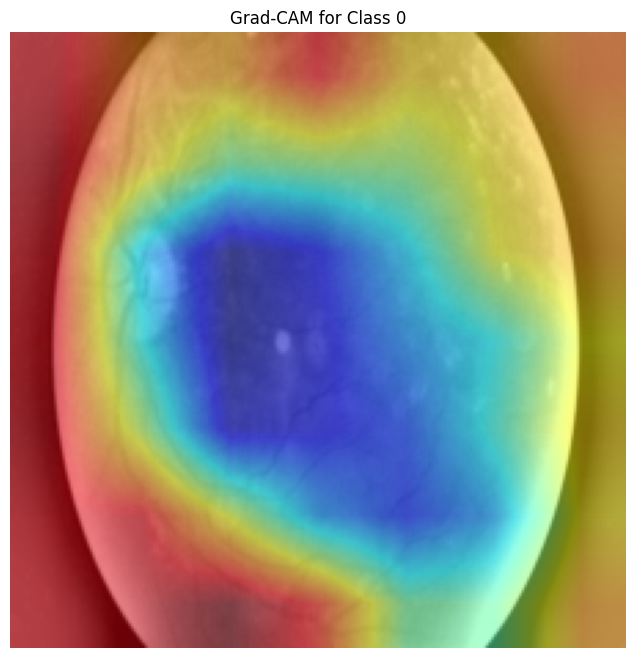

In [18]:
import cv2
import numpy as np
import torch.nn.functional as F

def grad_cam(model, image_tensor, class_idx=None):
    model.eval()
    image_tensor = image_tensor.unsqueeze(0).to(device)

    feature_maps = None
    gradients = None

    def forward_hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output

    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients
        gradients = grad_out[0]

    layer = model.layer4[-1]  # Last convolutional layer in ResNet
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)

    output = model(image_tensor)
    if class_idx is None:
        class_idx = torch.argmax(output).item()

    model.zero_grad()
    output[0, class_idx].backward()

    weights = gradients.mean(dim=[2, 3], keepdim=True)
    cam = (weights * feature_maps).sum(dim=1, keepdim=True)
    cam = F.relu(cam)

    # Detach the tensor from the computation graph before converting to NumPy
    cam = cam.detach().squeeze().cpu().numpy()
    cam = cv2.resize(cam, (224, 224))
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    # Convert image tensor back to PIL image
    image = image_tensor.cpu().squeeze().permute(1, 2, 0).numpy()
    image = (image - image.min()) / (image.max() - image.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_image = heatmap + np.float32(image)
    cam_image = cam_image / cam_image.max()

    plt.figure(figsize=(8, 8))
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM for Class {class_idx}")
    plt.axis("off")
    plt.show()

# Select a random test image
test_images, _ = next(iter(test_loader))
grad_cam(model, test_images[0])